In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/bardo.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 201, 1)

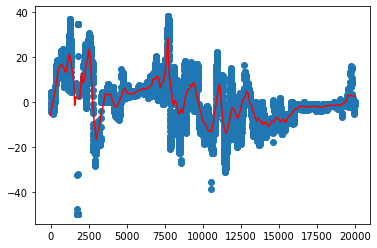

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
# grade_data = np.arctan(grade_data/100)
# yhat = np.arctan(grade_smooth/100)
# plt.scatter(distance_data, grade_data)
# plt.plot(distance_data, yhat, 'r')

In [7]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

grade_data = np.arctan(grade_data/100)

7670
337


In [8]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

# x_data = x_data[x_data <= distance]
# slope_data = slope_data[x_data <= distance]

In [9]:
# create GEKKO model
m = GEKKO()

In [10]:
t_est = 1 * 60 * 60
t_min = 0.7 * 60 * 60
t_max = 4 * 60 * 60

In [11]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [12]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
beta = (4 * 4184 * 1/75 * N_m * X)/(E0 * np.sqrt(S * tau))
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)
mu = (k*N_m*X)/(np.sqrt(S*tau))

In [13]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [14]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0
n0 = 0.00201818/N_m

e_crit = 0.15 * e0

In [15]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sigma0 * E_data/(e0 * e_crit) + 0.75 * sigma0 * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sigma0

# slope data to create spline
# x_data = np.linspace(0, 1, 3000)
# slope_data = np.array(600*[1/18 * np.pi] + 600 * [-1/18 * np.pi] + 600*[1/36 * np.pi] + 600 * [-1/36 * np.pi] + 600 * [1/9 * np.pi])

In [16]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [17]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
N = m.Var(value=n0, lb=0.0) # oxidation rate

sigma = m.Var(value=sigma0, lb=0) #breathing rate
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [18]:
# FV - final time
# tf = m.FV(value=t_est/t_scale,lb=t_min/t_scale,ub=t_max/t_scale)
tf = m.FV(value=t_est/t_scale, lb = 0.1)
tf.STATUS = 1

In [19]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [20]:
# energy decrease at the end
m.cspline(E, sigma, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [21]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v) + beta * N)*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(mu * N * (1 - N))*tf)
m.Equation(alpha * (sigma - u * v) + beta * N <= 0)
m.Equation((distance - X*x)*final<=0)

m.fix_final(E, 0)

In [ ]:
m.options.IMODE = 6
m.options.MAX_ITER=30000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 90.156.80.122_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           11
   Intermediates:            0
   Connections  :            6
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           3399
 Number of total equations: -         3200
 Number of slack variables: -          400
 ---------------------------------------
 Degrees of freedom       :           -201
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

In [ ]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm, np.array(sigma.value)/max(sigma.value), 'y-', lw=2, label=r'$\sigma$')
plt.plot(tm, np.array(N.value)/max(N.value), 'g--', lw=2, label=r'$N$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [ ]:
6281/3600